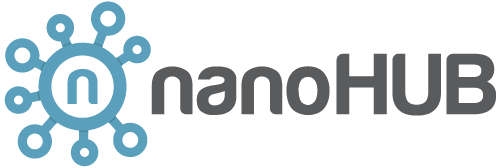

# Active Learning for melting temperature of MPCAs, powered by nanoHUB

## <i>David Farache</i>, <i>Juan Carlos Verduzco,</i> <i>Zachary McClure,</i> and <i>Alejandro Strachan, </i> Materials Engineering, Purdue University

## Overview

 * <b>Step 1.</b> Download initial dataset
 * <b>Step 2.</b> Create search space
 * <b>Step 3.</b> Create Random Forest Model
 * <b>Step 4.</b> Run Active Learning Workflow 

## Getting started and hints

 * Click on the links below to access each notebook.
 * Remember to click "Shift+Return" or click "Run" from the top bar to run each cell
 * To exit individual notebooks and return to this page, use File -> Close and Halt. "Terminate Session" (top right) will kill your entire Jupyter session.
 * The notebooks will be read only, you can make your own copy by downloading the notebook file (Menu File -> Download as... > Notebook (.ipynb)). You can upload this notebook to your main Jupyter directory within nanoHUB to run it again.

In [1]:
#Library Used in all Code
import numpy as np
import pandas as pd

#Used In Rule of Mixtures
import pymatgen as pymat
import mendeleev as mendel

#Random
np.random.seed(44) # Random Seed1
import random

# PLOTTING (MATPLOTLIB)
%matplotlib inline
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# PLOTTING (PLOTLY)
import plotly 
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

# ML
from lolopy.learners import RandomForestRegressor
from lolopy.metrics import root_mean_squared_error
from lolopy.metrics import standard_error
from sklearn.metrics import mean_absolute_error

# Meltheas TOOL
from simtool import findInstalledSimToolNotebooks, searchForSimTool
from simtool import getSimToolInputs, getSimToolOutputs, Run

MeltHEA = searchForSimTool('meltheas')
from IPython.display import clear_output
from IPython.display import display
from hublib.ui import FileUpload

# CITRINATION / MATMINER
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from sklearn.model_selection import KFold
from pymatgen import Composition

# PYTHON
import os
import sys
import glob
import os.path, time

# USED FOR ACQ FUNCTION
from scipy.stats import norm

<IPython.core.display.Javascript object>

# Import Initial Dataset
Here we load in the training/testing data set, remove unnecessary descriptors, and it turn into a pandas dataframe. Pandas is a library in python that can immediately turn data into a table and enable you to organize it simply. To display the initial data set simply uncomment display(initial_data). The compared_df is a dataset of only compositions to remove them from the whole search space to create an unexplored space.

In [2]:
#Get initial set for testing data
initial_data = pd.read_csv('../data/NewSmallCompositionDataSet.csv')

#Remove Columns No Longer Needed
initial_data = initial_data.drop(['Solid Tm'], axis=1)
initial_data = initial_data.drop(['Liquid Tm'], axis=1)
initial_data = initial_data.drop(['Minus'], axis=1)
initial_data = initial_data.drop(['Plus'], axis=1)
initial_data = initial_data.drop(['Unnamed: 0'], axis=1)

#Create Dataset Of Only Compositions
compared_df = initial_data.drop(['Simulated Tm'], axis=1)

#display(initial_data)

# All Plausible Composition Creator
Creates a pandas dataframe to develop a five element compositional space of [Cr, Co, Cu, Fe, Ni]. The set is created using linespace function from numpy and meshgrid, creating a grid of values from 0 to 1 with a step size of 0.1. Each composition is then limited to values below or equal to 0.5 and rows that sum to 1. This will create at set of 593 points that include both explored and unexplored compositions. To display uncomment display(plausible_compositions).

In [3]:
#Create lines to get values with .1 step size
nx = 11
x1 = np.linspace(0, 1, nx)
y, y1, y2, y3, y4 = np.meshgrid(x1, x1, x1, x1, x1)
positions = np.vstack([y.ravel(), y1.ravel(), y2.ravel(), y3.ravel(), y4.ravel()]).T

#Make dataframe, with previous limits, of all possible compositional combinations and that they add to 1 (100%)
all_permutations = pd.DataFrame(positions)
all_permutations["sum"]= all_permutations.sum(axis = 1)
plausible_compositions = all_permutations[all_permutations["sum"] == 1]

#Limit Values to 0.5 or below
plausible_compositions = plausible_compositions[plausible_compositions[0] <= 0.5] #Cr
plausible_compositions = plausible_compositions[plausible_compositions[1] <= 0.5] #Co
plausible_compositions = plausible_compositions[plausible_compositions[2] <= 0.5] #Cu
plausible_compositions = plausible_compositions[plausible_compositions[3] <= 0.5] #Fe
plausible_compositions = plausible_compositions[plausible_compositions[4] <= 0.5] #Ni

#Rounds to remove certain error created by meshgrid
plausible_compositions = plausible_compositions.round(1)

plausible_compositions = plausible_compositions.drop(["sum"], axis = 1)
initial_plausible_compositions = plausible_compositions
#display(plausible_compositions)

Incase of an error give by meshgrid or linespace function where the search space being created is to big, uncomment the code below to create the dataframe. Meshgrid is significantly faster than the code below but has a limit to the size of the search space one can develop within Nanohub but the code below can create any search space desired but will take significantly longer to run.

In [4]:
#nx = 11
#a = np.linspace(0, 1, nx)

#results = []

#for i in a:
#    for j in a:
#        for k in a:
#            for l in a:
#                for m in a:
#                    if i+j+k+l+m == 1:
#                        results.append([i,j,k,l,m])
#                        #print('working')
#all_res = pd.DataFrame(results)
#all_res = all_res[all_res[0] <= 0.5] #Cr
#all_res = all_res[all_res[1] <= 0.5] #Co
#all_res = all_res[all_res[2] <= 0.5] #Cu
#all_res = all_res[all_res[3] <= 0.5] #Fe
#all_res = all_res[all_res[4] <= 0.5] #Ni
#plausible_compositions = all_res
#plausible_compositions = plausible_compositions.round(1)
#initial_plausible_compositions = plausible_compositions

##display(all_res)

The code blow will remove the compositions of the explored space from the all compositional space, to develop the unexplored space (554 points). To display uncomment display(plausible_compositions).

In [5]:
#Rename df to match other dataframes
plausible_compositions = plausible_compositions.rename(columns = {0:'Cr',1:'Co',2:'Cu',3:'Fe', 4:'Ni'})

#Taking out replicas
df = pd.merge(plausible_compositions, compared_df, how='left', indicator = 'Exsist')
df = df[df['Exsist'] != 'both']
plausible_compositions = df.drop(['Exsist'], axis = 1)

#display(plausible_compositions)

# Retrieve Pymatgen Properties
The function creates a dataframe of elemental properties from input_string (desired elemental properties) and sample (string of element names). The properties of each element is imported from the pymatgen library. String_dict is an array of the properties one can choose to download from pymatgen and the string names can be added to the array actual_qued_values to create a dataframe of element properties. The values are placed within a pandas dataframe to then be taken and utilized to create property values via rule of mixtures using compositions from plausible_compositions dataframe. The element property dataframe is created with the columns being the elements and the rows being the material properties selected from pymatgen (if selecting different elements and properties it is advised to check if pymatgen contains values for those properties for the element your selecting). Uncomment final line to save created dataframe of elemental property as a csv.

In [6]:
#String to select characteristics
actual_qued_values = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity','CTE','hardness','boiling_point',
                         'atomic_mass','poissons_ratio','density_of_solid','en_gosh','melting_point']

sample = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']

def get_descriptors(input_string,sample):
    #dictionary values to choose from
    string_dict = ['bulk_modulus','youngs_modulus','CTE','thermal_conductivity','boiling_point','critical_temperature',
                  'vdw_radius','average_ionic_radius','atomic_radius','atomic_number','atomic_mass','molar_volume', 
                   'density_of_solid','hardness','poissons_ratio','period','group','en_gosh','electrical_resistivity', 'melting_point']

    #Creation of dictionary
    data_set = {}

    #Make dict of lists
    for length_string in range(len(string_dict)):
        data_set[string_dict[length_string]] = []

    #All plausbile compositions from before
    df2 = plausible_compositions

    #list of all things
    que_values = []

    #Import pymatgen properties and create dictionary of them
    for item in sample:
        element_object = pymat.Element(item)
        data_set[string_dict[0]].append(element_object.bulk_modulus) #bulk_modulus
        data_set[string_dict[1]].append(element_object.youngs_modulus) #youngs_modulus
        data_set[string_dict[2]].append(element_object.coefficient_of_linear_thermal_expansion) #CTE
        data_set[string_dict[3]].append(element_object.thermal_conductivity) #thermal conductivity
        data_set[string_dict[4]].append(element_object.boiling_point) #boiling_point
        data_set[string_dict[5]].append(element_object.critical_temperature) #critical temperature
        data_set[string_dict[6]].append(element_object.van_der_waals_radius) #vander wall radius
        data_set[string_dict[7]].append(element_object.average_ionic_radius) #average ionic radius
        data_set[string_dict[8]].append(element_object.atomic_radius) #atomic radius
        data_set[string_dict[9]].append(element_object.Z) #atomic number
        data_set[string_dict[10]].append(element_object.atomic_mass) #atomic mass
        data_set[string_dict[11]].append(element_object.molar_volume) #molar volume
        data_set[string_dict[12]].append(element_object.density_of_solid) #density_solid
        data_set[string_dict[13]].append(element_object.brinell_hardness) #brinell_hardness
        data_set[string_dict[14]].append(element_object.poissons_ratio) #poissons_ratio
        data_set[string_dict[15]].append(element_object.row) #period
        data_set[string_dict[16]].append(element_object.group) #group
        data_set[string_dict[17]].append(element_object.X) #en_gosh
        data_set[string_dict[18]].append(element_object.electrical_resistivity) #electrical_resistivity
        data_set[string_dict[19]].append(element_object.melting_point) #melting_point

    #Select properties from dictionary
    for descript in input_string:
        que_values.append(data_set[descript])

    #Create Final Dataframe
    df = pd.DataFrame(data = que_values, columns = sample, index = input_string) 
    display(df)
    return df

descriptors_df = get_descriptors(actual_qued_values,sample)
#descriptors_df.to_csv('AdjustedInitialSetData', index = False)

,Cr,Co,Cu,Fe,Ni
youngs_modulus,2.790000e+02,2.090000e+02,1.300000e+02,2.110000e+02,2.000000e+02
atomic_radius,1.400000e+00,1.350000e+00,1.350000e+00,1.400000e+00,1.350000e+00
electrical_resistivity,1.270000e-07,6.000000e-08,1.720000e-08,1.000000e-07,7.200000e-08
CTE,4.900000e-06,1.300000e-05,1.650000e-05,1.180000e-05,1.340000e-05
hardness,1.120000e+03,7.000000e+02,8.740000e+02,4.900000e+02,7.000000e+02
boiling_point,2.944000e+03,3.200000e+03,3.200000e+03,3.134000e+03,3.186000e+03
atomic_mass,5.199610e+01,5.893319e+01,6.354600e+01,5.584500e+01,5.869340e+01
poissons_ratio,2.100000e-01,3.100000e-01,3.400000e-01,2.900000e-01,3.100000e-01
density_of_solid,7.140000e+03,8.900000e+03,8.920000e+03,7.874000e+03,8.908000e+03
en_gosh,1.660000e+00,1.880000e+00,1.900000e+00,1.830000e+00,1.910000e+00


# Applying Rule of Mixtures
The function below applies rule of mixture based upon df2 (dataframe of different alloy compositions), df (pandas dataframe descriptors from the pymatgen library), and sample (string list of the elements). This returns a dataframe of the supposed properties of the alloy based upon its composition. This version assumes that the appropriate method to determine the properties of alloys via the atomic percent of elements times the elemental property. Uncommenting any of the displays below will have the dataframes created from the function be displayed. Uncommenting known_compositions_rule_mixtures.to_csv('AdjustedInitialSetData', index = False) will save the dataframe as a file of the supposed properties of the initial data set alloys.

<br>
<font size = '6'> $$ Property_{alloy} = \sum Composition_iProperty_i $$ </font> 

In [7]:
#Apply Rule of Mixtures
def rule_mixtures(df2,df,sample): 
    #Creats column of first rule mixture descriptors to concatenate to
    cr = 0
    for comps in sample:
        cr = cr+df2[comps]*df[comps][0]
    cr = cr.to_frame()

    #Concatenate rest of compositions with rule of mixtures applied
    for x in range(1,len(actual_qued_values)):
        cf = 0
        for comps in sample:
            cf = cf + df2[comps]*df[comps][x]
        cf.to_frame()
        cr = pd.concat([cr,cf], axis=1)

    #Renames columns to descriptors
    cr.columns = actual_qued_values
    return cr

plausible_compositions_rule_mixtures = rule_mixtures(plausible_compositions,descriptors_df,sample)
known_compositions_rule_mixtures = rule_mixtures(compared_df,descriptors_df,sample)
#display(plausible_compositions_rule_mixtures)
#display(known_compositions_rule_mixtures)
#known_compositions_rule_mixtures.to_csv('AdjustedInitialSetData', index = False)

# Data Preperation
Two dataframes of compositions are created:
<br> all_rule_mixtures: A dataframe of the rule of mixtures for all (593) compositions in both the explored and non-explored space
<br> all_compositions: Dataframe of all the plausible compositions granted the limitations given earlier

Two numpy arrays are then made for training and testing the data:
<br> create_label: descriptor data for training and predicting model
<br> all_labels: testing data (MD Simulated Temperature)


In [8]:
#Concatenate values
all_rule_mixtures = pd.concat([known_compositions_rule_mixtures,plausible_compositions_rule_mixtures])
all_compositions = pd.concat([compared_df,plausible_compositions])

#display(all_compositions)
#display(all_rule_mixtures)

In [9]:
#Set testing and training data
all_values = all_rule_mixtures.values.tolist()
all_labels = initial_data['Simulated Tm'].tolist()

# List of lists are turned into Numpy arrays
all_values = np.array(all_values, dtype = float)
all_labels = np.array(all_labels, dtype = float)

#Ccreate array to grab training data and later save MD simulated runs during Active learning
create_label = np.zeros((plausible_compositions_rule_mixtures.shape[0],), dtype = int)
all_labels = np.concatenate((all_labels,create_label), axis = 0)

# Getting CSVS for Sequential Learning
Incase of a desire to continue the Active Learning Workflow from previous experiment or due to connection failure, this code will append previous runs to the explored set. The code looks for files in the directory that contain string name 'melting_8labels'. If you wish to append runs from a certain folder, swap 'melting_8labels' for whatever name the file has a string contained in multiple files you wish to append. To prevent the addition of previous runs simply comment the code below except for the first line as it will cause an error in the following section. If you want certain files added but not others, it is recommended to save files into another files as the code will only search for files within the same directory as the code (path = os.getcwd()). If you want it to access files in another folder simply change path, to the folder or folders.

In [10]:
list_seq_learn = []
path = os.getcwd()

#print(path)

list_of_files = sorted(os.listdir(path), key=os.path.getctime)
for docs in list_of_files:
    if 'melting_8labels' in docs:
        list_seq_learn.append(docs)
print(list_seq_learn)

[]


# Random Forest Creation and Prediction
A Random Forest is created with the hyperparameters for tress equal to 350 trees. The data is split 80/20 for training of the model. 

In [11]:
X = all_values.copy() #descriptors
y = all_labels.copy() #all labels  

# assign values
model = RandomForestRegressor(num_trees = 350) #model
#print(model.__init__)

entry_number_init = initial_data.shape[0] #starting point of initial data
in_train = np.zeros(len(X), dtype=np.bool) #make all false

in_train[:entry_number_init] = True #turns false to true 

#in_train[np.where(y!=0)] = True

print('Picked {} training entries'.format(in_train.sum()))

nsamples = in_train.sum()
train_fraction = 0.8
train_idx = int(train_fraction*nsamples)

print (X.shape, y.shape)

#Get previous runs of sequential and use them
if list_seq_learn:
    y_counter = 0
    seq_learn_data = pd.read_csv(list_seq_learn[-1])
    for val in seq_learn_data['Index']:
        in_train[val] = True
        y[val] = seq_learn_data['Simulated Tm'][y_counter]
        y_counter = y_counter + 1    

model.fit(X[:train_idx, :], y[:train_idx])
test_pred, test_std = model.predict(X[train_idx:nsamples, :], return_std=True)
pred, std = model.predict(X, return_std=True)
#print(in_train)

Picked 39 training entries
(593, 11) (593,)


# Parity Plot
A parity plot represents the effectiveness of a machine learning via how well the predicted value aligns with actual values. 
<br> This is dependent on how well the points align with a linear fit, that is if RF Prediction = MD Predictions it will be linear.

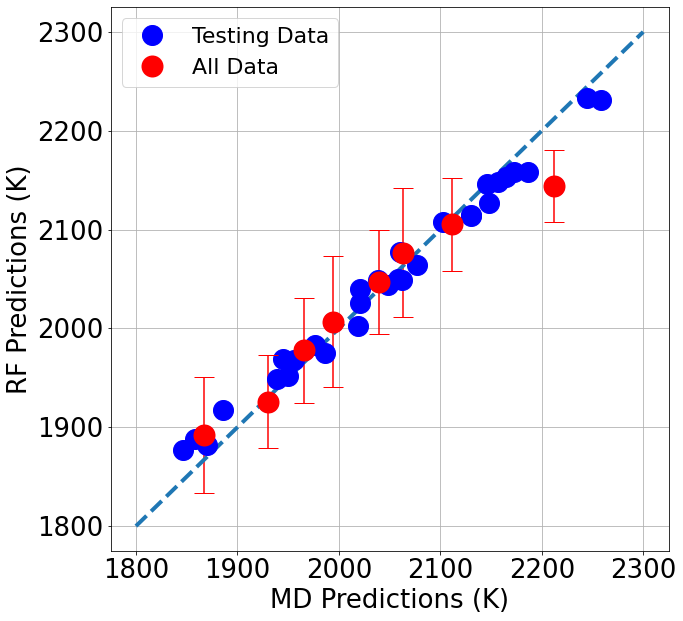

In [12]:
fig = plt.figure(figsize = (10,10))

plt.plot([1800,2300],[1800,2300],linewidth=4,linestyle='--')
plt.plot(y[:nsamples], pred[:nsamples], 'o',color='blue', markersize=20, label='Testing Data')
plt.plot(y[train_idx:nsamples], test_pred, 'o', color='red',
         markersize=20, linewidth=4,
         markerfacecolor='red',
         markeredgecolor='red',
         markeredgewidth=2,
         label='All Data')
plt.errorbar(y[train_idx:nsamples], test_pred,yerr = test_std,color='red',fmt='o',capsize =10)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid()
plt.legend(fontsize=22)
plt.ylabel('RF Predictions (K)', fontsize=26)
plt.xlabel('MD Predictions (K)', fontsize=26)
plt.show()

# Residual Testing
Perform KFold validation for model and plot. Models with well calibrated uncertainties would produce a Gaussian distribution with a mean of zero and unit-standard deviation.

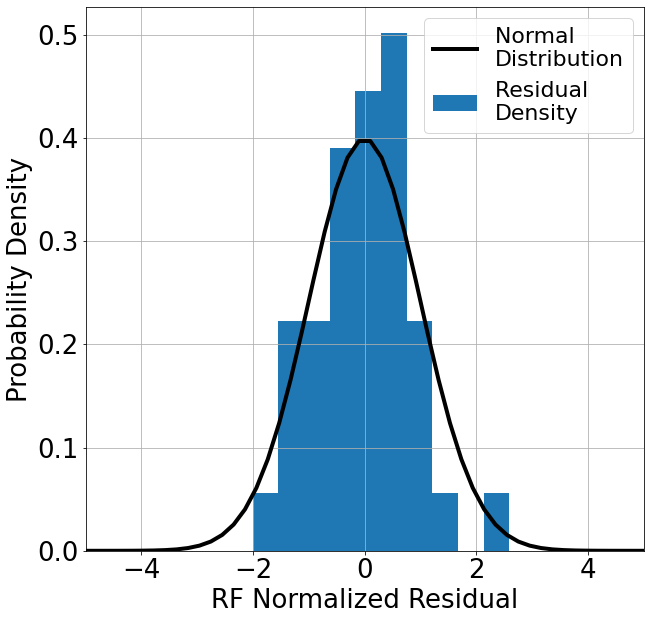

In [13]:
all_values_all = np.array(X[:nsamples])
all_labels_all = np.array(y[:nsamples])

model = RandomForestRegressor(num_trees=350)

y_resid = []
y_uncer = []

for train_id, test_id in KFold(10, shuffle=True).split(all_values_all):
    model.fit(all_values_all[train_id], all_labels_all[train_id])
    yf_pred, yf_std = model.predict(all_values_all[test_id], return_std=True)
    y_resid.extend(yf_pred - all_labels_all[test_id])
    y_uncer.extend(yf_std)
   
resid = np.divide(y_resid, y_uncer)

#Create Residual Plot Below
x_ev = np.linspace(-5, 5, 50) #Create normal distribution line

fig = plt.figure(figsize = (10,10))

plt.hist(resid, density=True, label='Residual \nDensity', bins=10)
plt.plot(x_ev, norm.pdf(x_ev), color='black', linewidth=4, linestyle='-', label='Normal \nDistribution')
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlim([-5,5])
plt.grid()
plt.legend(fontsize=22)
plt.ylabel('Probability Density', fontsize=26)
plt.xlabel('RF Normalized Residual', fontsize=26)
#plt.title('Information Acquistion Functions', fontsize=18)

fig.show()

# Initial model error testing
The code below will run a Random Forest Model while varying the values within the training and testing dataset to determine the mean absolute error for the model.

In [14]:
from sklearn.utils import shuffle

train_fraction = 0.8
train_idx = int(train_fraction*nsamples)
mean_abs_error = []
n_runs = 30
for _ in range(n_runs):
    all_values_all, all_labels_all = shuffle(all_values_all, all_labels_all, random_state=_) #shuffle dataset
    train_values, test_values = np.split(all_values_all, [train_idx]) #split into train and test values
    train_labels, test_labels = np.split(all_labels_all, [train_idx]) #split into train and test labels
    
    model = RandomForestRegressor(num_trees = 350) #model if iterate through

    model.fit(train_values, train_labels) #fit model

    test_pred, test_std = model.predict(test_values, return_std=True) #get perdicted values and error of model

    mean_abs_error.append(mean_absolute_error(test_labels,test_pred))

#Print mean absolute error for runs, the mean of the error, and standard deviation of the error
#print(mean_abs_error)
print(np.mean(mean_abs_error))
print(np.std(mean_abs_error))

36.179329564462655
12.407028835531689


# Applying Acquisition Function
The selection of Acquisition Function is depending one what value IAF equals (MM, UCB, MLI, MEI, MU, Random).
<br>
<font size = '6'>
    $$ MM:  x^*= argmax \; E[M(x_i )] $$
    <br>
    <br>
    $$ UCB:  x^*= argmax(E[M(x_i )] + K * \sigma[M(x_i )]) $$
    <br>
    <br>
    $$ MLI:  x^*= argmax \frac{E[M(x_i )] - E[M(x_{best} )]}{\sigma[M(x_i )]} $$
    <br>
    <br>
    $$ MEI: x^*= argmax  \rho  ( E[M(x_i )] - E[M(x_{best})], \sigma [M(x_i)] ) $$
       $$ with \; \rho \; (z,s) = \begin{cases}
          s \phi'(\frac{z}{s}) +
          z \phi(\frac{z}{s}) & s > 0 \\
          max(z,0) & s = 0
          \end{cases} $$
    <br>
    <br>
    $$ MU:  x^*= argmax \; \sigma [M(x_i)] $$
</font>

The code below runs the Active Learning Workflow using the meltheas tool. 
The meltheas tool is a simulation being utilized to predict the melting temperature for alloys compromised of Cr, Co, Cu, Fe, and/or Ni. The parameters of the simulation is time per simulation in nanoseconds, solid fraction temperature, liquid fraction temperature, configuration seed, velocity seed, and box length. 

The varaible n_steps determines the amount of experiments/iterations that the Active Workflow will run through. If searching for highest or lowest value, the variable patience_counter can be uncommented and will early stop the loop when certain value is achieved.

Below is a function required for MEI (Maximum Expected Improvement):

In [15]:
def piecewise(m,s): # argument of the function, m is the prediction - top training point, s is the uncertainty of that point
    if s > 0:
        return s*norm.pdf(m/s)+m*norm.cdf(m/s)
    else:
        return max(np.max(m), 0) 

39
-------------------------------------------------------------
Experiment #  0
505
[0.1, 0.4, 0.1, 0.3, 0.1]
submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/fe6039150c164d7c8ad18b3d78148d15/inputs.yaml
       RUNS/fe6039150c164d7c8ad18b3d78148d15
submit --local /apps/bin/ionhelperRunSimTool.sh meltheas r39
       RUNS/fe6039150c164d7c8ad18b3d78148d15/inputs.yaml


Input Notebook:  /apps/meltheas/r39/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing: 100%|??????????| 26/26 [17:59<00:00, 41.53s/cell] 


Saved output files: ['final.jpg']
simToolSaveErrorOccurred = 0
simToolAllOutputsSaved = 1
submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/fe6039150c164d7c8ad18b3d78148d15/inputs.yaml
       RUNS/fe6039150c164d7c8ad18b3d78148d15
Predicted melting temperature for this potential:  2320.9379955223885
95% confidence interval:  2.78797549388263
Fraction of system solid:  0.0006510416666666666
Fraction of system liquid:  0.98828125
Crystal Structure Info:  [3.0, 23.0, 1.0, 24.0, 3.0, 4554.0, 4608.0]


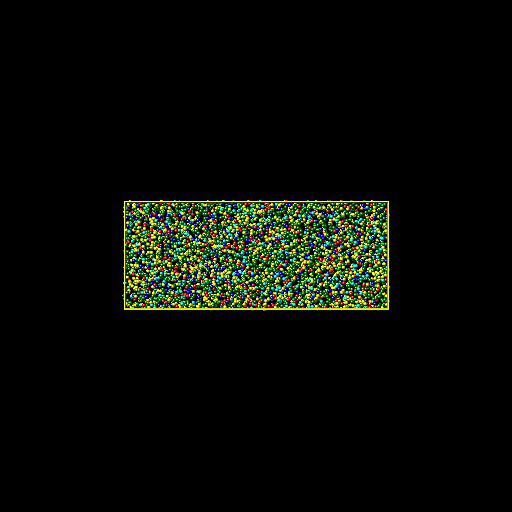

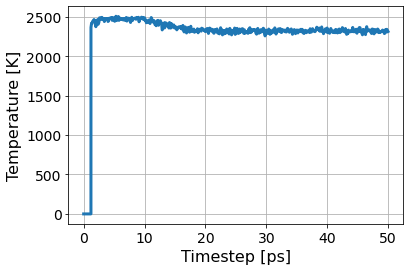

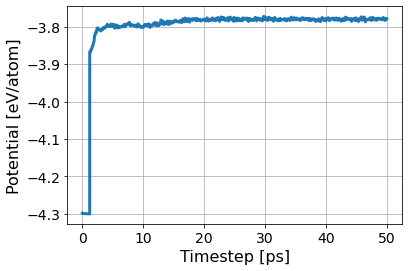

submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/ddb42d8e1612475abceb3718b2bceaeb/inputs.yaml
       RUNS/ddb42d8e1612475abceb3718b2bceaeb
submit --local /apps/bin/ionhelperRunSimTool.sh meltheas r39
       RUNS/ddb42d8e1612475abceb3718b2bceaeb/inputs.yaml


Input Notebook:  /apps/meltheas/r39/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing: 100%|??????????| 26/26 [18:20<00:00, 42.34s/cell]   


Saved output files: ['final.jpg']
simToolSaveErrorOccurred = 0
simToolAllOutputsSaved = 1
submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/ddb42d8e1612475abceb3718b2bceaeb/inputs.yaml
       RUNS/ddb42d8e1612475abceb3718b2bceaeb
Predicted melting temperature for this potential:  2201.679822885572
95% confidence interval:  5.047634054738898
Fraction of system solid:  0.0010850694444444445
Fraction of system liquid:  0.9854600694444444
Crystal Structure Info:  [5.0, 36.0, 3.0, 21.0, 2.0, 4541.0, 4608.0]


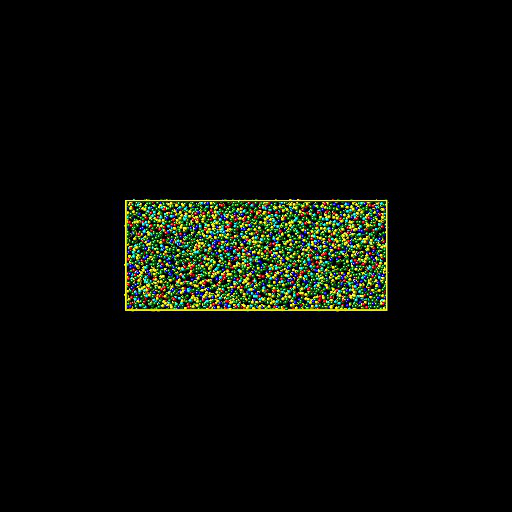

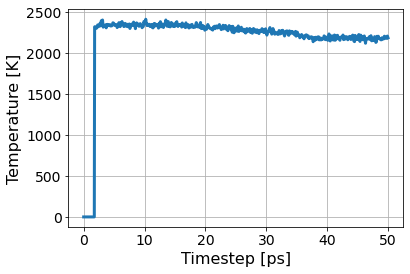

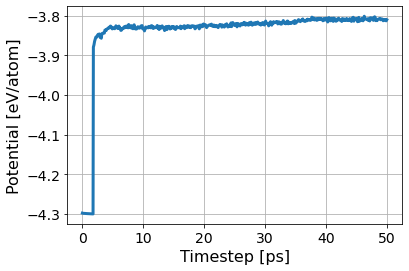

submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/7e18e6990c0b4fd7b01a7c1c26351649/inputs.yaml
       RUNS/7e18e6990c0b4fd7b01a7c1c26351649
submit --local /apps/bin/ionhelperRunSimTool.sh meltheas r39
       RUNS/7e18e6990c0b4fd7b01a7c1c26351649/inputs.yaml


Input Notebook:  /apps/meltheas/r39/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing: 100%|??????????| 26/26 [18:24<00:00, 42.49s/cell] 


Saved output files: ['final.jpg']
simToolSaveErrorOccurred = 0
simToolAllOutputsSaved = 1
submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/7e18e6990c0b4fd7b01a7c1c26351649/inputs.yaml
       RUNS/7e18e6990c0b4fd7b01a7c1c26351649
Predicted melting temperature for this potential:  2223.539523880597
95% confidence interval:  2.880906051895146
Fraction of system solid:  0.291015625
Fraction of system liquid:  0.6890190972222222
Crystal Structure Info:  [1341.0, 48.0, 25.0, 19.0, 0.0, 3175.0, 4608.0]


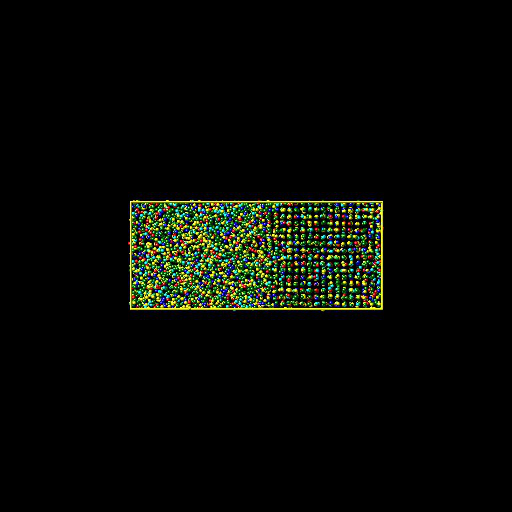

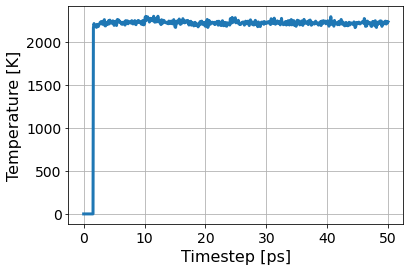

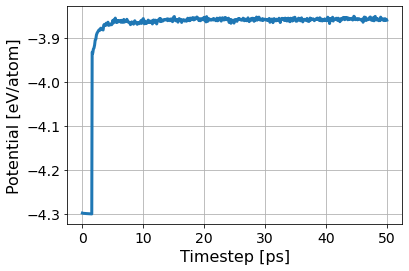

submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/5e448477f7bf482cb550a2d477b4fa6f/inputs.yaml
       RUNS/5e448477f7bf482cb550a2d477b4fa6f
submit --local /apps/bin/ionhelperRunSimTool.sh meltheas r39
       RUNS/5e448477f7bf482cb550a2d477b4fa6f/inputs.yaml


Input Notebook:  /apps/meltheas/r39/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing: 100%|??????????| 26/26 [18:02<00:00, 41.65s/cell]   


Saved output files: ['final.jpg']
simToolSaveErrorOccurred = 0
simToolAllOutputsSaved = 1
submit --local /apps/bin/ionhelperGetArchivedSimToolResult.sh meltheas r39
       RUNS/5e448477f7bf482cb550a2d477b4fa6f/inputs.yaml
       RUNS/5e448477f7bf482cb550a2d477b4fa6f
Predicted melting temperature for this potential:  2214.399273631841
95% confidence interval:  3.0376302044735404
Fraction of system solid:  0.5047743055555556
Fraction of system liquid:  0.482421875
Crystal Structure Info:  [2326.0, 34.0, 18.0, 7.0, 0.0, 2223.0, 4608.0]


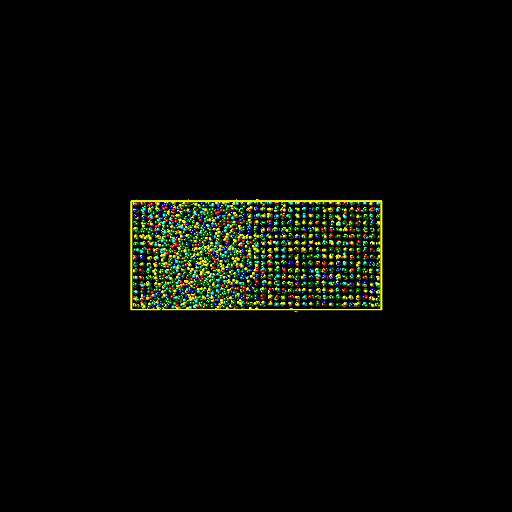

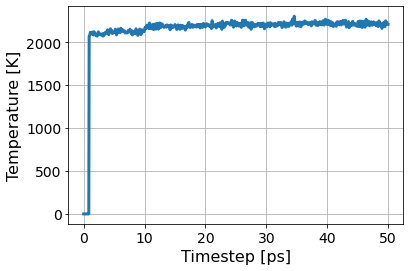

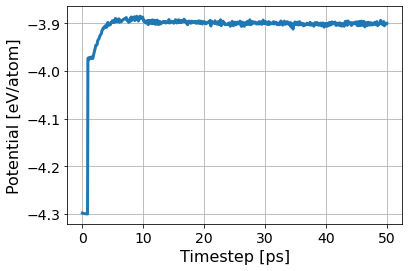

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
#Set inputs
n_steps = 1 # number of expirements
time_per_simmul = 50 #Time per simulation
box_len = 18 #box length
iaf = "UCB" #select acquisition function (MM,UCB,MLI,MEI,MU,Random)

#Adjust data and indices for running
all_inds = set(range(len(y))) #set indexes
actual_exp = np.sum(in_train)-len(initial_data)
#gif_images = [] #list to save gifs as 2D array

history_train = [list(set(np.where(in_train)[0].tolist()))]
current_train_inds = []
#reset_comps = all_compositions.reset_index(drop=True)

#Create dataframe to save values to make into excel
saved_data = pd.DataFrame(columns=['IAF','Composition','Experiment',"Simulated Tm","Predicted Tm","Predicted Uncertainty","T_Solid","T_Liquid","Index"]) #Create Columns for Dataframe to Save data from Training
df2 = pd.DataFrame(columns = sample) #Create dataframe to save compositions of elements from string sample

patience_counter = 0

print(len(history_train[-1]))

for i in range(n_steps):

    print("-------------------------------------------------------------")
    print("Experiment # ", i)
    
    current_train_inds = history_train[-1].copy()

    current_search_inds = list(all_inds.difference(current_train_inds))
    
    #Random Forest fitting and predicting
    model.fit(X[current_train_inds], y[current_train_inds]) #train model, with entry_number
    current_y_pred, current_y_std = model.predict(X[current_search_inds], return_std=True) #pred

    # ACQUISITION FUNCTIONS
    
    # EARLY STOPPING / ACQUISITION
    
    if iaf == "MM":
    
        index_of_prediction = np.argmax(current_y_pred)    # MM  
        
        if np.max(current_y_pred) < np.max(y[current_train_inds]):
            patience_counter +=1
        else:
            patience_counter = 0
    
    elif iaf == "UCB":
        
        index_of_prediction = np.argmax([sum(x) for x in zip(current_y_pred, current_y_std)]) # UCB     
        
        if np.max([sum(x) for x in zip(current_y_pred, current_y_std)]) < np.max(y[current_train_inds]):
            patience_counter +=1
        else:
            patience_counter = 0     
    
    elif iaf == "MLI":
    
        index_of_prediction = np.argmax(np.divide(current_y_pred - np.max(y[current_train_inds]), current_y_std)) # MLI
    
        if np.max(current_y_pred) < np.max(y[current_train_inds]):
            patience_counter +=1
        else:
            patience_counter = 0
            
    elif iaf == "MEI":
      
        cons = np.max(y[current_train_inds])
        index_of_prediction = np.argmax( [piecewise(mn-cons, sd) for mn,sd in zip(current_y_pred, current_y_std )]) #MEI
        
        if np.max(current_y_pred) < np.max(y[current_train_inds]):
            patience_counter +=1
        else:
            patience_counter = 0
        
    elif iaf == "MU":
        
        index_of_prediction = np.argmax(current_y_std) # MU
        
        if np.max(current_y_std) < 50:
            patience_counter +=1
        else:
            patience_counter = 0
            
    else:
        index_of_prediction = np.random.choice(current_search_inds)           # Random    
    
#     if patience_counter > 15:
#         print("Early Stop")
#         break
        
    chosen_index_forsimul = current_search_inds[index_of_prediction]    
    composition_forsimul = all_compositions.iloc[chosen_index_forsimul] #compositions for simulation
    
    #printing index and composition
    print(chosen_index_forsimul)
    print(list(composition_forsimul))

    # RUNNING MELTHEAS SIM

    # setting inputs
    sim_gif = []
    flag = False
    plus = 0.50
    minus = 0.25    
    iteration = 0
    
    T_ROM = current_y_pred[index_of_prediction]    
    
    while (flag == False):
        inputs = getSimToolInputs(MeltHEA)
        
        random_seed = int(np.random.randint(1,10000,1)[0]) 
        velocity_seed = int(np.random.randint(1,10000,1)[0])
        
        inputs.rand_seed.value = random_seed #Assign Random Seed for Configuration
        inputs.velocity_seed.value = velocity_seed #Assign Random Seed for Velocity
                
        inputs.time.value = time_per_simmul #Time given per simulation in picoseconds
        inputs.box_length.value = box_len # Box Length
        c1, c2, c3, c4, c5 = list(composition_forsimul) #Split Composition
        inputs.composition1.value = c1 #Cr
        inputs.composition2.value = c2 #Co
        inputs.composition3.value = c3 #Cu
        inputs.composition4.value = c4 #Fe
        inputs.composition5.value = c5 #Ni
        
        inputs.Tsolid.value = (T_ROM-(T_ROM*minus)) #Set Solid Phase Temperature
        inputs.Tliquid.value = (T_ROM+(T_ROM*plus)) #Set Liquid Phase Temperature

        # running and outputs 
        r = Run(MeltHEA, inputs) #Call Meltheas Tool

        melting_temperature_obtained = r.read('melting_temperature') #MD Temperature
        if r.read('Coexistence') and r.read('Converged') == 1: #Determine complete composition tested
            flag = True
        else:
            flag = False
        fraction_solid = r.read('fraction_solid') 
        fraction_liquid = r.read('fraction_liquid')
        #sim_gif.append(r.read('final_snapshot')) #Add final image of simulation

        #Print Outputs
        print ("Predicted melting temperature for this potential: ", (r.read('melting_temperature')))
        print ("95% confidence interval: ", (r.read('melting_temperature_ci')))
        print ("Fraction of system solid: ", (r.read('fraction_solid')))
        print ("Fraction of system liquid: ", (r.read('fraction_liquid')))
        print ('Crystal Structure Info: ', r.read('counts_array'))
        display(r.read('final_snapshot'))

        #Adjust Temperature Based Upon Fraction of Liquid/Solid Phase
        if (flag == False):
            if fraction_solid >= fraction_liquid:
                T_ROM += T_ROM*.05 #~80
            elif fraction_liquid >= fraction_solid:
                T_ROM -= T_ROM*.05 #~80
                
        #Graph from the melting workflow
        import matplotlib.pyplot as plt
        #Total number of atoms for 8x8 BCC unit cell cross-section and user input box-length
        if inputs.crystal_structure.value == 'bcc':
            atom_count = 8*8*2*inputs.box_length.value

        #Total number of atoms for 8x8 FCC unit cell cross-section and user input box-length
        elif inputs.crystal_structure.value == 'fcc':
            atom_count = 8*8*4*inputs.box_length.value

        ts = r.read('time_series')

        temperature = r.read('temperature_series')
        plt.plot([x/1000 for x in ts],temperature,linewidth=3)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Timestep [ps]',fontsize=16)
        plt.ylabel('Temperature [K]',fontsize=16)
        plt.grid()
        plt.show()

        potential_energy = r.read('potential_energy_series')
        plt.plot([x/1000 for x in ts],np.divide(potential_energy,atom_count),linewidth=3)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Timestep [ps]',fontsize=16)
        plt.ylabel('Potential [eV/atom]',fontsize=16)
        plt.grid()
        plt.show() 

    
    #Add melting temperature to array
    y[chosen_index_forsimul] = melting_temperature_obtained
    
    #Ending when desired temp found
    if melting_temperature_obtained > 2600:
        continue

    current_train_inds.append(chosen_index_forsimul) #from inputs choosing untrained indexes randomly
    history_train.append(current_train_inds) #storage list, of sets of values created throughout sequential learning
    
    #Get values to save to dataframe
    composition_string = " ".join([i + ' ' + str(j) for i, j in zip(["Cr","Co","Cu","Fe","Ni"], composition_forsimul)])
    
    T_Solid = inputs.Tsolid.value
    T_Liquid = inputs.Tliquid.value
    
    #Save to dataframe
    data = pd.DataFrame([iaf,composition_string, actual_exp, melting_temperature_obtained, current_y_pred[index_of_prediction],
                         current_y_std[index_of_prediction], T_Solid, T_Liquid,chosen_index_forsimul, random_seed, velocity_seed])
    data = data.T
    data = data.rename(columns = {0:'IAF', 1:'Composition',2:'Experiment',3: "Simulated Tm",4: "Predicted Tm",5:"Predicted Uncertainty",6:"T_Solid",7:"T_Liquid",8:"Index", 9:"RandomSeed", 10:"VelocitySeed"})
    saved_data = saved_data.append(data)
    actual_exp = actual_exp + 1
    
    #Save dataframe at this point into file
    csv_file_name = '{0}_melting_8labels_{1}Pico_Run{2}.csv'.format(iaf,time_per_simmul,len(list_seq_learn))    
    saved_data.to_csv(csv_file_name, index = False)
    
    #Getting Images for Gif
    #gif_images.append(sim_gif)
    

Creates name for csv file and can be changed to any string
.format enables one to add variable string/values into string. The ones include are iaf (Acquisition Function), time_per_simmul (Time per simulation), and len(list_seq_learn) (How many addition data files that have been added for training)

In [17]:
 csv_file_name = '{0}_melting_8labels_{1}Pico_Run{2}.csv'.format(iaf,time_per_simmul,len(list_seq_learn)) 

# Save Runs Into CSV

The code below will append the dataframe from the previous file to on the one created within the current runs

In [18]:
if list_seq_learn:
    saved_data = saved_data.append(seq_learn_data)
saved_data = saved_data.sort_values(by='Experiment')
display(saved_data)

,Composition,Experiment,IAF,Index,Predicted Tm,Predicted Uncertainty,RandomSeed,Simulated Tm,T_Liquid,T_Solid,VelocitySeed
0,Cr 0.1 Co 0.4 Cu 0.1 Fe 0.3 Ni 0.1,0,UCB,505,2213.56,68.9089,1701,2214.4,2846.78,1423.39,3619


Save dataframe as csv file with name below (will replace previous file if named the same)

In [19]:
saved_data.to_csv(csv_file_name, index = False)

# Active Learning Prediction to Result Graph 

Adjust the initial traning set to simplify dataset for creating the following graph

In [20]:
initial_set = [list(all_compositions.iloc[x]) for x in range(39)]
compositions_initial_set = [" ".join([i + ' ' + str(j) for i, j in zip(["Cr","Co","Cu","Fe","Ni"], X)]) for X in initial_set]

initialset_data = pd.DataFrame([np.arange(-19.5,0,0.5),y[:39],compositions_initial_set])
initialset_data = initialset_data.T
initialset_data = initialset_data.rename(columns = {0:'Experiment',1:'Simulated Tm',2:'Composition'})

Open symbols represent  MD  simulated  melting  temperatures.   The  filled  symbols  with  error  bars  represent  RFpredicted  melting  temperatures. The function scatter_acq takes in two parameters: 1) Array csv_files, which is an array of string arrays containing names/directory of files containing the Active Learning Workflow data 2) The initialset_data is the adjusted initial dataset to be present as the black dots within the graph. Actual image of figure can be adjusted in the first section layout. The following section loads the selected datasets. Next section creates the black circle points display for the initial training dataset. The next section creates graph (uncertainty, prediction temperature, MD simulated temperature) for each file given in the array and assigns a color (rgba_colors) and a shape (pred_shape). Putting to more than 6 files will lead to an error.
<br> The current file is 200ps run for MLI, to change to your file comment csv_files = ['../data/200picoRuns_RandomSeeds/Trial1/MLI_melting_200Pico_Final.csv'], and uncomment the line below it.

In [21]:
def scatter_acq(csv_files,initialset_data):
    # layout
    fig_dict = {
        "data": [],
        "layout": {"width":1000, "height":2000},
    }
    fig_dict["layout"] = dict(paper_bgcolor ='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', width = 1400, height = 700, font=dict(size=36,family='Times New Roman'))
    fig_dict["layout"]["xaxis"] = dict(title=go.layout.xaxis.Title(text='Number of Experiments', font=dict(size=36)),  range=[-20,40], zeroline= False, tickmode = 'array', tickvals = [0,5,10,15,20,25,30,35,40], gridwidth= 1, gridcolor ='gray',linewidth=2, linecolor='gray',tickfont=dict(size=36,family='Times New Roman'),ticklen=15, mirror=True, ticks='outside', showline=True)
    fig_dict["layout"]["yaxis"] = dict(title=go.layout.yaxis.Title(text='Melting Temp (K)',  font=dict(size=36)), range=[1400,2600], zeroline= False, tickmode = 'array', gridwidth= 1, gridcolor ='gray', tickfont=dict(size=36,family='Times New Roman'), mirror=True, ticks='outside', showline=True, linewidth=2, linecolor='gray')
    fig_dict["layout"]["showlegend"] = False
    fig_dict["layout"]["legend"] = dict(x=.87,y=.99,bgcolor="White", bordercolor="Black", borderwidth=2)
    fig_dict["layout"]["hovermode"] = "closest"
    ########################################################################################################################################
    acq_frame = []
    IAF_working = []

    for files in csv_files:
        acq_data = pd.read_csv(files)
        complete_dataset = pd.concat([initialset_data, acq_data])
        acq_frame.append(complete_dataset)

    dataset = acq_frame[0]
    experiments = list(np.arange(len(dataset) - len(initialset_data)))
    
    #########################################################################################################################################
    initial_set_trace = go.Scatter(x = dataset["Experiment"][:len(initialset_data)], y = dataset["Simulated Tm"][:len(initialset_data)], text = dataset["Composition"][:len(initialset_data)], mode = 'markers', 
                          marker= dict(size= 12, color='black'), name= "Initial Set", hovertemplate = "Experiment # None <br><br><b>Simulated Tm:</b>   %{y} <br><b>Composition:</b>   %{text}")

    fig_dict["data"].append(initial_set_trace)
    #########################################################################################################################################
    #make string of rgb colors must follow #,#,#
    rgba_colors = ['255,0,255','0,0,255','255,0,0','34,139,34','255,165,0','0,255,255']
    shapes = []
    pred_shape = ['pentagon','triangle-down','square','star','x']
    for Shape in pred_shape:
        shapes.append(Shape+'-open')
        
    counter = 0
    
    for data_frames in range(len(acq_frame)):
        dataset = acq_frame[data_frames]

        pred_name = "RF Predictions ({0:s})".format(dataset['IAF'].iloc[len(initialset_data)])
        simul_name = "MD Simulations ({0:s})".format(dataset['IAF'].iloc[len(initialset_data)])
        pred_color = 'rgba({0:s},1)'.format(rgba_colors[counter])
        simul_color = 'rgba({0:s},1)'.format(rgba_colors[counter])
        
        acq_working = dataset[dataset["IAF"] == dataset['IAF'].iloc[len(initialset_data)]]
        
        current_predicted_trace_data = go.Scatter(
                x = list(dataset["Experiment"][len(initialset_data):]), 
                y = list(dataset["Predicted Tm"][len(initialset_data):]),
                error_y= {"type":'data', "array":list(dataset["Predicted Uncertainty"][len(initialset_data):])},
                text = list(dataset["Composition"][len(initialset_data):]), mode = 'markers', marker= dict(symbol=pred_shape[counter],size= 12, color=pred_color), name= pred_name,
                hovertemplate = "Experiment # %{x} <br><br><b>Predicted Tm:</b>   %{y} <br><b>Composition:</b>   %{text}")

        current_simulated_trace_data = go.Scatter(x = dataset['Experiment'][len(initialset_data):], y =  dataset['Simulated Tm'][len(initialset_data):], text = dataset['Composition'][len(initialset_data):], mode = 'markers', 
                    marker= dict(symbol=shapes[counter],size= 12, color=simul_color), name= simul_name, hovertemplate = "Experiment # %{x} <br><br><b>Simulated Tm:</b>   %{y} <br><b>Composition:</b>   %{text}",
                    showlegend=True)

        
        IAF_working.append(acq_working)   
        fig_dict["data"].append(current_predicted_trace_data)        
        fig_dict["data"].append(current_simulated_trace_data)
        counter = counter + 1

    ##############################################################################################################################################

    fig = go.Figure(fig_dict)
    
    fig.show()  
        
csv_files = ['../data/200picoRuns_RandomSeeds/Trial1/MLI_melting_200Pico_Final.csv']
#csv_files = [csv_file_name]

scatter_acq(csv_files,initialset_data)

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




# Best Composition Graph

Adjust dataset so that composition is in percent instead of decimal. Find location of best composition (where Fe is 50% and remaining 50% is either or split between Co and Ni) and place into array. States how many of the best composition the file has found and their indices

In [22]:
comp = acq_data = pd.read_csv('../data/200picoRuns_RandomSeeds/Trial1/MLI_melting_200Pico_Final.csv')
#comp = acq_data = pd.read_csv(csv_file_name)

saved_data = pd.DataFrame(columns=['Experiment','Cr','Co',"Cu","Fe",'Ni'])
important_indexes = []

for rows in range(0,len(comp)):
    composition_array = comp.iloc[rows]['Composition'].split(' ')
    #display(composition_array)
    data = pd.DataFrame([rows,float(composition_array[1])*100,float(composition_array[3])*100,float(composition_array[5])*100,float(composition_array[7])*100,float(composition_array[9])*100]) #Makes compositions as percent instead of decimal
    data = data.T
    data = data.rename(columns = {0: 'Experiment',1:'Cr', 2:'Co', 3: "Cu",4:"Fe",5:'Ni'})
    saved_data = saved_data.append(data)
    if (float(composition_array[3])+float(composition_array[7])+float(composition_array[9])) == 1 and float(composition_array[7]) == 0.5: #Looks for best compositions and location
        important_indexes.append(rows) #Add indices of best compositions
    
#display(saved_data)
print(('{0} of 6 of the best compositions have been found in this run').format(len(important_indexes)))
print(important_indexes)

6 of 6 of the best compositions have been found in this run
[13, 14, 15, 16, 17, 19]


In the following code we create a bar chart to represent the compositions of the MPCAs queried as our best performers. 

In [23]:
if len(important_indexes) > 0:
    fig = go.Figure(data=[
        go.Bar(name='Fe', x=saved_data['Experiment'][important_indexes[0]:(important_indexes[5]+2)], y=saved_data['Fe'][important_indexes[0]:(important_indexes[-1]+2)],marker_color='#ca0020'),
        go.Bar(name='Ni', x=saved_data['Experiment'][important_indexes[0]:(important_indexes[5]+2)], y=saved_data['Ni'][important_indexes[0]:(important_indexes[-1]+2)],marker_color='#a6d96a'),
        go.Bar(name='Co', x=saved_data['Experiment'][important_indexes[0]:(important_indexes[5]+2)], y=saved_data['Co'][important_indexes[0]:(important_indexes[-1]+2)],marker_color='#0047ab'),
        go.Bar(name='Cr', x=saved_data['Experiment'][important_indexes[0]:(important_indexes[5]+2)], y=saved_data['Cr'][important_indexes[0]:(important_indexes[-1]+2)],marker_color='#808080'),
        go.Bar(name='Cu', x=saved_data['Experiment'][important_indexes[0]:(important_indexes[5]+2)], y=saved_data['Cu'][important_indexes[0]:(important_indexes[-1]+2)],marker_color='#808080'),
    ])
    fig.update_layout(
                                width = 800, #4
                                height = 600, #3
                                font=dict(size=36,family='Times New Roman'),
                                showlegend = False,
                                barmode = 'stack',    # Change the bar mode to stack
                                bargroupgap=0.1, # gap between bars of the same location coordinate.

                                xaxis_title_text='Experiment', # xaxis label
                                yaxis_title_text='Composition (%)', # yaxis label

                                #paper_bgcolor ='rgba(0,0,0,0)',
                                plot_bgcolor='rgba(0,0,0,0)',
                                xaxis_gridwidth= 1,
                                xaxis_gridcolor ='gray',
                                xaxis_linewidth=2, 
                                xaxis_linecolor='gray',
                                yaxis_gridwidth= 1,
                                yaxis_gridcolor ='gray',
                                yaxis_linewidth=2, 
                                yaxis_linecolor='gray',
                                xaxis = dict(mirror = True, ticklen = 15),
                                yaxis = dict(mirror = True, ticklen = 15, range = [0,100]),

                            )
    fig.show()
else:
    print('No best composition found')
